In [1]:
# Loading libraries

import os

import pandas as pd
import numpy as np

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords.words('English')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, classification_report

In [2]:
# Loading data
path = os.getcwd()
folder = path + "/cleaned_df/"

train = []
test = []
val = []

for file in sorted(os.listdir(folder)):
    fname = file.split('.')[0]
    df = pd.read_csv(folder + file)
    if re.search("train", fname):
        train.append(df)
    if re.search("test", fname):
        test.append(df)
    if re.search("validation", fname):
        val.append(df)

df_names = [file.split('stance_')[1] if 'stance_' in file else file for file in sorted(os.listdir(folder))]
df_names = [file.split('_')[0] for file in df_names]
df_names = sorted(set(df_names), key=df_names.index)

In [3]:
# Creating a dictionary to facilitate access to the dataframes

train_named = dict(zip(df_names, train))
test_named = dict(zip(df_names, test))
val_named = dict(zip(df_names, val))

In [4]:
# Looking at the abortion training dataset

pd.set_option('display.max_colwidth', None)
train_named['abortion'].head(10)

,text,label
0,remind ourselves that love means willing give until hurts mother teresa,1
1,and most islanders have different definitions timely access irony peipoli peivotes,0
2,life precious are babies mothers fathers please support the sanctity human life think,1
3,too many people are taking this seriously,0
4,dude won freeshirt from never win anything lol abort,0
5,like yall can try and push your views anyway but will remain,0
6,just because legal doesnt make god honoring samesexmarriage themovie audacitymovie,0
7,maybe thats what wants,0
8,being mothers womb isnt safe guess neither are churches specifically black ones whoisburningblackchurches,1
9,nothing with its not choice nor yours dictate what another woman chooses feminism,2


In [5]:
train_named['abortion'].label.value_counts().sort_index()

0    158
1    319
2    109
Name: label, dtype: int64

In [6]:
# Creating a subset of relevant stances to predict

subset_names = ['abortion', 'atheism', 'climate', 'feminist', 'hillary']

/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


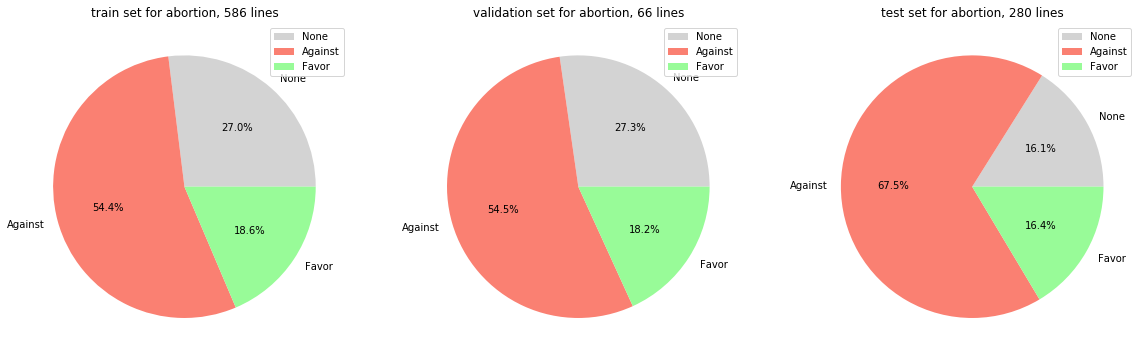

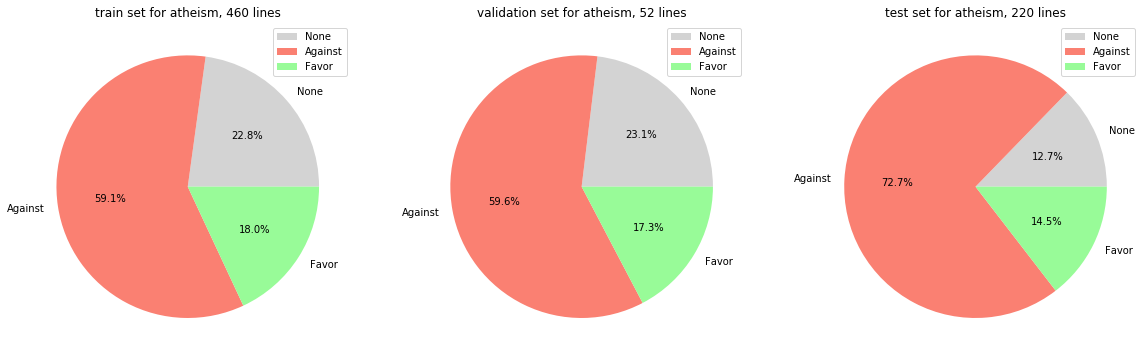

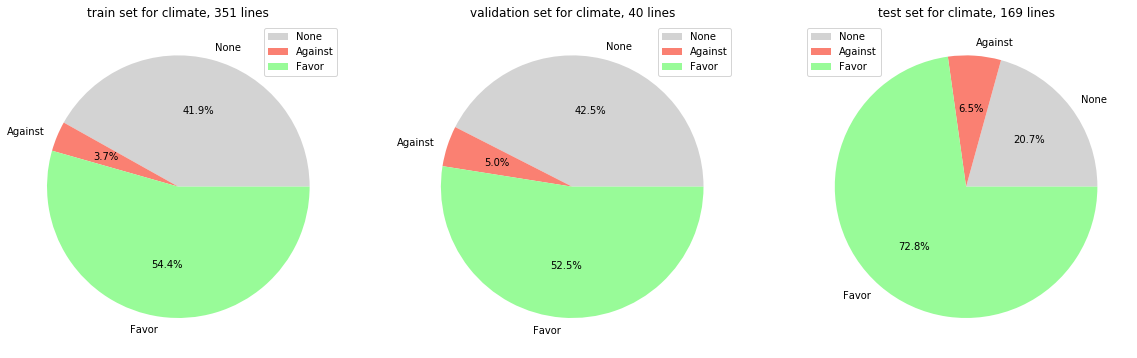

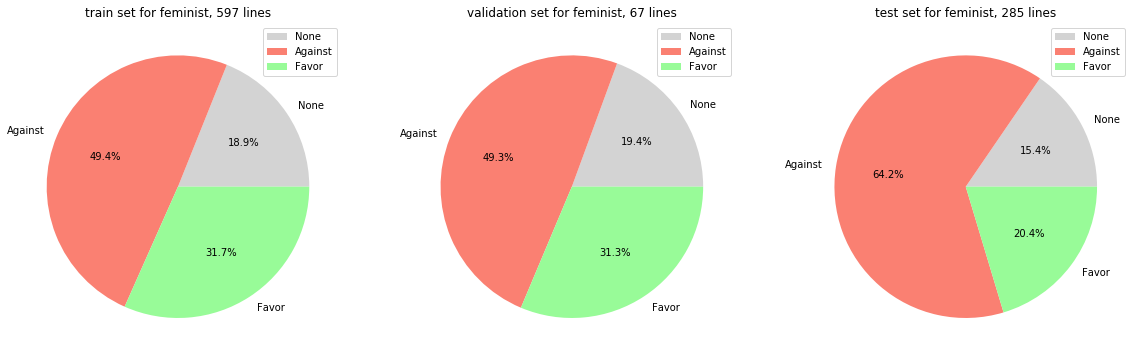

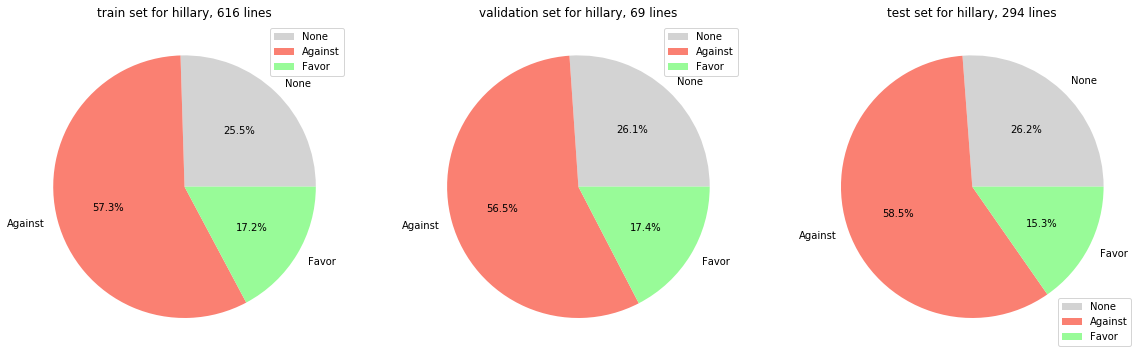

In [7]:
# Visualizing the distribution of support and opposition to topics

for subset in subset_names:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
    for i, (df, name) in enumerate(zip([train_named[subset], val_named[subset], test_named[subset]], ['train', 'validation','test'])):
        y = df.label.value_counts().sort_index().values / len(df) * 100
        ax[i].pie(y, colors=['lightgray', 'salmon', 'palegreen'], autopct='%1.1f%%', labels=['None', 'Against', 'Favor'])
        ax[i].legend()
        ax[i].set_title(f'{name} set for {subset}, {len(df)} lines')
    fig.show()

It is important to note the class imbalances and how they differ both between topics and train, validation and test datasets. Specifically, most tweets across all topics are classified as being against that topic, with the one exception being the climate dataset, which has most tweets in favor. 

This is pretty consistent across the train and validation sets, but the majority class is much greater for the test sets. For instance, while roughly 52-54% of the tweets in the climate dataset are in favor, this jumps to almost 73% in the test set. This is also the case for abortion, atheism and feminist, which means that a prediction strategy that classifies all tweets as "Against" in these cases can still have high accuracy, though lower precision and recall for the other two classes.

Additionally, the "in favor" and "against" classes are not equally distributed between the datasets, with "in favor" usually the least likely class or quite similar to "none". The most significance difference in class balance is in the climate dataset, where opposing tweets make up between 3.7-6.5% of the available tweets, compared to 52.5-72.8% of tweets in favor of climate.

In [8]:
# Tokenizing and removing stopwords

tokens_favor = []
tokens_against = []

for subset in subset_names:
    
    pro_token = [word_tokenize(tweets) for tweets in train_named[subset].loc[train_named[subset].loc[:, 'label'] == 2, 'text'].values]
    anti_token = [word_tokenize(tweets) for tweets in train_named[subset].loc[train_named[subset].loc[:, 'label'] == 1, 'text'].values]
    
    stop_words = set(stopwords.words('English'))
    
    pro_tok = []
    for tweet in pro_token:
        tok = [w for w in tweet if not w in stop_words]
        pro_tok.append(tok)
    
    tokens_favor.append(pro_tok)
    
    anti_tok = []
    for tweet in anti_token:
        tok = [w for w in tweet if not w in stop_words]
        anti_tok.append(tok)
    
    tokens_against.append(anti_tok)


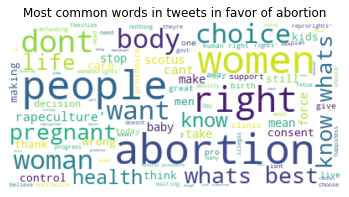

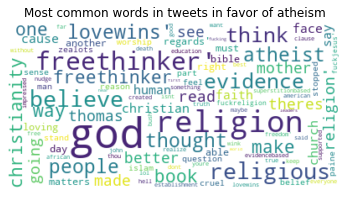

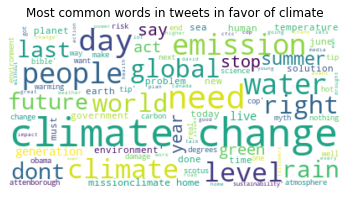

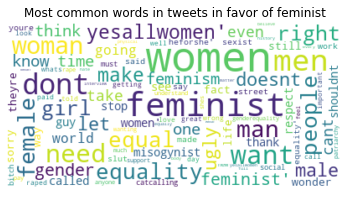

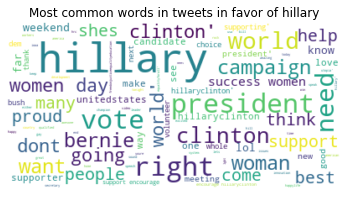

In [9]:
# Visualizing the most common words in favor of the topics

for i in range(len(tokens_favor)):
    texts = [' '.join(tokens) for tokens in tokens_favor[i]]
    favor_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts))
    
    plt.figure()
    plt.title(f'Most common words in tweets in favor of {subset_names[i]}')
    plt.imshow(favor_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

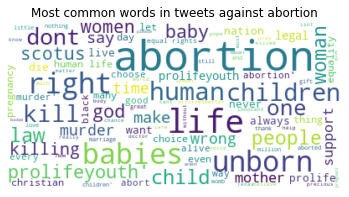

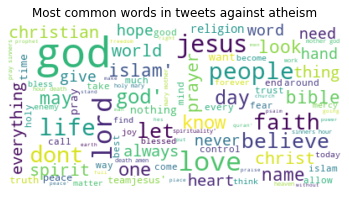

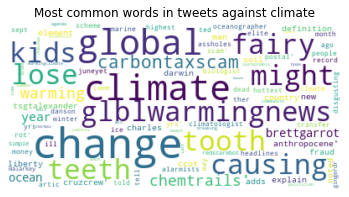

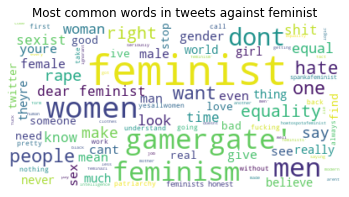

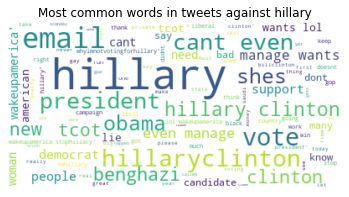

In [10]:
# Visualizing the most common words against the topics

for i in range(len(tokens_against)):

    texts = [' '.join(tokens) for tokens in tokens_against[i]]
    against_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts))
    
    plt.figure()
    plt.title(f'Most common words in tweets against {subset_names[i]}')
    plt.imshow(against_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

After removing stopwords, we can more clearly show the distribution of words for favorable and unfavorable views on each topic. 

Tweets in favor of abortion will more commonly cite "people", "abortion", "women", and "right", while those against abortion tend to mention "abortion", "life", "right", "babies", and "unborn". Notice that words like "abortion" and "right" are often used in both; they are words that relate more to the discussion at hand, rather than a specific stance on the issue. However, tweets that take a stance against abortion are more likely to approach the topic by emphasizing "unborn babies", "killing", and "human", whereas those in favor mention "choice" and "body" more.

There is less of a difference in the atheism, climate and feminist datasets in terms of high-frequency words, but we can nonetheless identify key words that could help predict the stance on the issue. Though "god" is used often in both pro and against tweets, tweets in favor of atheism are more likely to reference "religion" broadly in comparison to those opposed to atheism, who mention "jesus", "lord" and "love".

Similarly, tweets referencing climate mention "climate change" and "global" frequently, though those supporting are more likely to talk about "emission", "level", "people", "water" and use words like "need", whereas those opposed tweet "causing", "glblwarmingnews", "might" and "lose". Weirdly enough, they also mention "fairy" and "tooth"/"teeth". 

There are many overlaps in words used in both classes of tweets referring to feminism, with words such as "feminist", "women", "equality", "men". Nevertheless, we can identify a few tokens used in tweets that are pro-feminism that are not as common in anti-feminist tweets, such as "yesallwomen", a Twitter hashtag where women shared their experiences with misogyny and violence against women.

Finally, tweets about Hillary Clinton mention her name frequently, as well as words related to voting and president, but while those in favor reference "right" and "campaign" more often, tweets against tend to focus on "email", "benghazi" and "obama".

In [11]:
# Defining the metrics we want to use

def get_metrics(y_trues, y_preds, average, verbose=True):
    
    recall = recall_score(y_trues, y_preds, average = average) * 100
    precision = precision_score(y_trues, y_preds, average = average) * 100
    accuracy = accuracy_score(y_trues, y_preds) * 100
    f1 = f1_score(y_trues, y_preds, average = average) * 100
    
    if verbose:
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'Accuracy: {accuracy:.2f}')
        print(f'F1: {f1:.2f}')
        
    return recall, precision, accuracy, f1 

In [12]:
# Scores obtained by a random classifier 

precisions, recalls, accuracies, f1s = [], [], [], []

for i in range(1000):
    trues = np.random.randint(0, 3, 1000)
    preds = np.random.randint(0, 3, 1000)
    
    precision, recall, accuracy, f1 = get_metrics(trues, preds, average = 'weighted', verbose=False)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1s.append(f1)

print('Final metrics')
print(f'Precision: {np.mean(precisions):.2f} ({np.std(precisions):.2f})')
print(f'Recall: {np.mean(recalls):.2f} ({np.std(recalls):.2f})')
print(f'Accuracy: {np.mean(accuracies):.2f} ({np.std(accuracies):.2f})')
print(f'F1: {np.mean(f1s):.2f} ({np.std(f1s):.2f})')

Final metrics
Precision: 33.31 (1.46)
Recall: 33.38 (1.48)
Accuracy: 33.31 (1.46)
F1: 33.31 (1.47)


In [13]:
# ROC AUC score obtained by a random classifier 

roc_aucs = []

for i in range(1000):
    trues = np.random.randint(0, 3, 1000)
    pred_probas = []
    
    for i in range(1000):
        preds = np.random.uniform(0, 1, 3)
        summ = sum(preds)
        preds_norm = preds/summ

        pred_probas.append(preds_norm)
    
    roc_auc = roc_auc_score(trues, pred_probas, average = 'weighted', multi_class = 'ovr')
    roc_aucs.append(roc_auc)

print(f'ROC AUC: {np.mean(roc_aucs):.2f} ({np.std(roc_aucs):.2f})')

ROC AUC: 0.50 (0.01)


For our baseline model, we build on a simple dictionary-based method of predicting classes. 

First, we build two dictionaries: one for words associated with tweets in favor of a topic, and another for words against the topic. Which words should be included in what dictionary is determined by the probability of it being a favorable or opposing word; this probability threshold varies depending on the topic of analysis because, as we've shown before, some topics have many common words used by both classes (such as feminism), while others like abortion are able to draw better distinctions. This is done using the training set.

Then, we define our baseline model by counting in each tweet the number of words it contains from each dictionary. If it contains more favorable words than unfavorable words, we predict a label of ``2: in favor``. If it contains more unfavorable words, we predict a label of ``1: against``. If the number of words belonging to both dictionaries is the same, we predict a label of ``0: None``.

We train the dictionary on the training set and make predictions on the validation set, tuning the threshold and minimum word count parameters. Reported here is just the best baseline model we achieved. Note that this model is not very sophisticated and poses challenges for under-represented classes as well as those examples in which the words used don't vary much between tweets in favor and against, as it doesn't take in the context of the tweet. Thus, while we expect to perform better than random, we don't expect to do nearly as well as the SOA.

In [14]:
# Creating dictionaries for favorable and opposition tweets based on the most frequent words

thresh = [0.25, 0.5, 0.25, 0.6, 0.80] # using different thresholds for the different sets
min_count = [5, 10, 5, 10, 5]

favor_dicts = []
against_dicts = []

for subset, i in zip(subset_names, range(len(tokens_favor))):
    favor_texts = train_named[subset].loc[train_named[subset].loc[:, 'label'] == 2, 'text'].values
    against_texts = train_named[subset].loc[train_named[subset].loc[:, 'label'] == 1, 'text'].values
    
    vectorizer = CountVectorizer(min_df=min_count[i])
    vectorizer.fit([' '.join(tokens) for tokens in tokens_favor[i]] + 
               [' '.join(tokens) for tokens in tokens_against[i]])
    
    X_fav = vectorizer.transform([' '.join(tokens) for tokens in tokens_favor[i]])
    X_aga = vectorizer.transform([' '.join(tokens) for tokens in tokens_against[i]])
    
    X = np.concatenate((np.array(X_fav.sum(axis=0))[0, :].reshape(-1, 1), 
                        np.array(X_aga.sum(axis=0))[0, :].reshape(-1, 1)), axis=1)
    X = X / X.sum(axis=1).reshape(-1, 1)
    
    proba_fav = sorted({word: proba for word, proba in zip(vectorizer.get_feature_names_out(),
                                                    X[:, 0])}.items(), key=lambda x: x[1], reverse=True)
    
    favor_dictionary = [x[0] for x in proba_fav if x[1] > thresh[i]]
    favor_dicts.append(favor_dictionary)

    proba_aga = sorted({word: proba for word, proba in zip(vectorizer.get_feature_names_out(),
                                                    X[:, 1])}.items(), key=lambda x: x[1], reverse=True)

    against_dictionary = [x[0] for x in proba_aga if x[1] > thresh[i]]
    against_dicts.append(against_dictionary)

In [15]:
# Creating the baseline model

def get_outputs(texts, dictionary): 
    
    # count how many words in the tweet belong to each dictionary 
    
    outputs = []
    for text in texts:
        founds = re.findall(r'\b(?:{})\b'.format('|'.join(dictionary)), text)
        n = len(founds)
        outputs.append(n)
        
    return outputs

def get_final_outputs(favor_outputs, against_outputs): 
    
    # predict in favor, against or neutral based on count
    
    assert len(favor_outputs) == len(against_outputs), 'ValueError: both lists should have the same size'
    outputs = []
    for fav, aga in zip(favor_outputs, against_outputs):
        if fav > aga:
            outputs.append(2)
        elif fav < aga:
            outputs.append(1)
        else:
            outputs.append(0)
    
    return outputs

def get_baseline_metrics(texts, trues, favor_dictionary, against_dictionary, verbose=True, average = 'weighted'):
    
    # return the metrics for the baseline model
    
    favor_outputs = get_outputs(texts, favor_dictionary)
    against_outputs = get_outputs(texts, against_dictionary)
    
    outputs = np.array(get_final_outputs(favor_outputs, against_outputs))
    precision, recall, accuracy, f1 = get_metrics(trues, outputs, average = average, verbose=True)
    
    return outputs

In [16]:
# Applying the baseline model to the validation set

baseline_scores = []
for subset, i in zip(subset_names, range(len(tokens_favor))):
    print(f'The scores for {subset} are...')
    baseline_score = get_baseline_metrics(val_named[subset].text, val_named[subset].label,
                                       favor_dicts[i], against_dicts[i], verbose = True, average = 'weighted')
    
    baseline_scores.append(baseline_score)

The scores for abortion are...
Precision: 68.55
Recall: 65.15
Accuracy: 65.15
F1: 61.56
The scores for atheism are...
Precision: 69.17
Recall: 63.46
Accuracy: 63.46
F1: 64.91
The scores for climate are...
Precision: 61.65
Recall: 65.00
Accuracy: 65.00
F1: 62.66
The scores for feminist are...
Precision: 44.76
Recall: 44.78
Accuracy: 44.78
F1: 40.36
The scores for hillary are...
Precision: 58.35
Recall: 43.48
Accuracy: 43.48
F1: 43.94


/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# After tuning the thresh and min_count params based on the validation set performance, we apply it to the test set

baseline_scores = []
for subset, i in zip(subset_names, range(len(tokens_favor))):
    print(f'The scores for {subset} are...')
    baseline_score = get_baseline_metrics(test_named[subset].text, test_named[subset].label,
                                       favor_dicts[i], against_dicts[i], verbose = True, average = 'weighted')
    
    baseline_scores.append(baseline_score)

The scores for abortion are...
Precision: 59.49
Recall: 58.57
Accuracy: 58.57
F1: 57.30
The scores for atheism are...
Precision: 68.18
Recall: 60.45
Accuracy: 60.45
F1: 62.75
The scores for climate are...
Precision: 68.59
Recall: 67.46
Accuracy: 67.46
F1: 67.17
The scores for feminist are...
Precision: 58.23
Recall: 52.98
Accuracy: 52.98
F1: 52.93
The scores for hillary are...
Precision: 50.74
Recall: 50.00
Accuracy: 50.00
F1: 48.62


/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In general, our test predictions were worse than our validation predictions, which is to be expected as we tuned the relevant parameters in order to maximize F1 for the validation set.

In [18]:
for i, subset in enumerate(subset_names):
    print(classification_report(test_named[subset].label, baseline_scores[i]) + 
          f'This is the classification report for {subset}.')

              precision    recall  f1-score   support

           0       0.32      0.60      0.42        45
           1       0.73      0.70      0.72       189
           2       0.31      0.09      0.14        46

    accuracy                           0.59       280
   macro avg       0.45      0.46      0.42       280
weighted avg       0.59      0.59      0.57       280
This is the classification report for abortion.
              precision    recall  f1-score   support

           0       0.26      0.61      0.36        28
           1       0.81      0.67      0.73       160
           2       0.41      0.28      0.33        32

    accuracy                           0.60       220
   macro avg       0.49      0.52      0.48       220
weighted avg       0.68      0.60      0.63       220
This is the classification report for atheism.
              precision    recall  f1-score   support

           0       0.37      0.63      0.47        35
           1       0.00      0.00   

/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

The classification reports show the precision, recall, and F1-score for each class (none, against, and in favor), as well as the macro and weighted averages across all classes. Precision is the proportion of correctly identified instances of that class among all instances that were classified as that class, while recall is the proportion of correctly identified instances of that class among all instances that actually belong to that class, and F1-score is the harmonic mean of precision and recall. 

For the abortion classification task, the model achieved an overall accuracy and recall of around 58.6, and precision of 59.5, leading to a weighted F1 of 57.30. The precision for class 1 (against) was high at 73%, which can be seen in the Confusion Matrix below, as the model predicted 182 tweets to be against, of which 133 actually were. However, the precision for classes 0 and 2 were relatively low at 32% and 31%, respectively, which suggests that the model struggled to correctly classify instances into these two classes. The recall for class 0 was not far off from that for class 1, while the recall for class 2 was the lowest at 0.09. This tells us that the model missed a significant number of instances that belong to class 2: out of 46 tweets in favor, it only identified 4. Finally, the macro averages generally perform worse than the weighted averages, suggesting that the classifier is performing well on the larger class (against), but poorly on the smaller ones (in favor and none).

In the atheism task, the model achieved an overall accuracy and recall of around 60.5, precision of 68.18 and weighted F1 of 62.75. Once again, the precision for tweets against was high at 81%, and it shows a very similar pattent to the abortion task, with lower precision for classes none (26%) and in favor (41%), and a reasonably close recall rate for 0 an 1 (around 61% an 67%, respectively). Out of all of the true tweets labeled 0s and 1s, it correctly identified more than 60% of them, but it managed to predict less than 30% of the true 2s. The weighted averages are higher than the macro averages, and this is another model that fails on the minority classes.

The climate classification task shows a different result, but this can be attributed to the fact that the majority class in this case is "in favor", rather than "against". As we've shown before, it is the only classification task in which this occurs. The model's overall performance is an accuracy and recall of 67.5%, a precision of 68.6% and a weighted F1 of 67.17. It does really well at precision and recall for the majority class (2: in favor), with 84% an 75% respectively, but fails to correctly predict any of the true tweets labeled 1 (against).  This leads to a 0% precision, recall and F1-score for that class, which only had 11 tweets in the sample. 

For the feminist and Hillary Clinton tasks, we continue to see the performing worse than random for the minority classes, but oing a terrific job at predicting the majority class. An interesting feature in the feminist dataset is that recall rate for 0s is actually higher than the recall rate for 1s, even tough thef former is the minority in the data. This is because, while it predicts as 0s many tweets that are actually 1s, it mostly classifies true 0s as 0s. This leads to an overall precision of 58.23, recall and accuracy of roughly 53% and weighted F1 of around the same size, with a macro F1 of 41. A similar result is found for the Hillary set but with lower overall scores, in part due to a near-zero F1 for the "in favor" class.

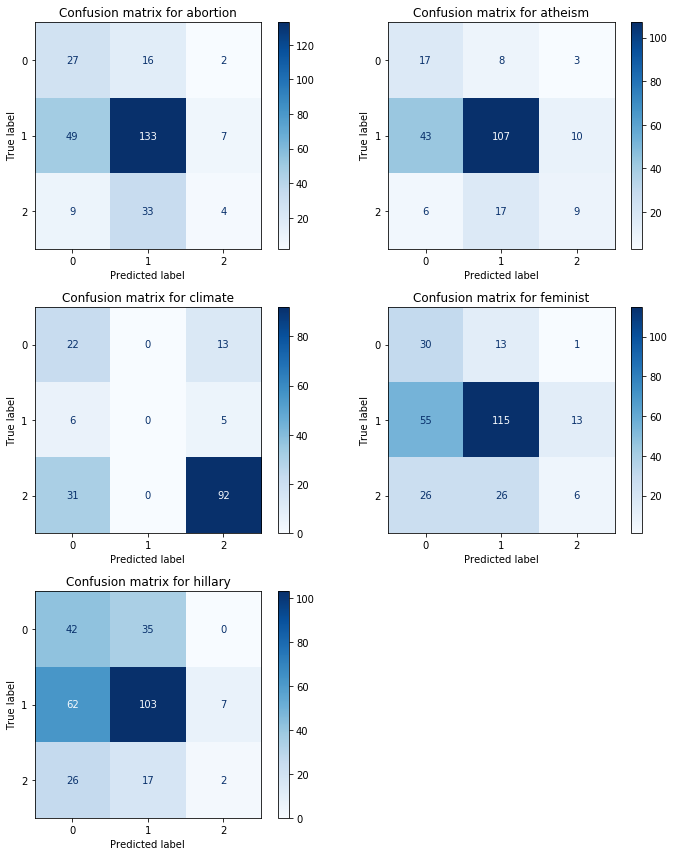

In [19]:
# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

# Loop through the subsets and scores
for i, subset in enumerate(subset_names):
    row = i // 2
    col = i % 2

    # Calculate the confusion matrix and create a ConfusionMatrixDisplay object
    cm = confusion_matrix(test_named[subset].label, baseline_scores[i], labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(cm)

    # Plot the confusion matrix in the appropriate subplot
    disp.plot(cmap="Blues", ax=axs[row, col])
    axs[row, col].set_title(f'Confusion matrix for {subset}')

# Add an empty subplot for the fifth figure
fig.delaxes(axs[2, 1])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [20]:
abortion_outcomes = pd.DataFrame({'text': test_named['abortion']['text'], 'label': test_named['abortion']['label']})
abortion_outcomes['predicted'] = baseline_scores[0]
abortion_outcomes[abortion_outcomes.label != abortion_outcomes.predicted].head(20)

,text,label,predicted
1,where the childcare program which you said would place loneparents istooyoung,1,0
7,many ways christians right here america already are the great satan gaymarriage drugs wakeupamerica,1,0
9,denounceharper because his religious ties are responsible for the marchforlife antichoice rallies parliament hill,1,0
11,the government has not been able point any improved health outcomes for women law macedonia hrctte,1,0
14,giving birth not pushing women toward death,1,0
25,anti choice laws are sexist because they only effect women,2,1
26,antichoice laws are telling these women theyre incapable and shouldnt make decisions that involve their own body,2,1
31,how many locationefficient affordablehousing units could the nyc metro pop create built over all its cemeteries,0,1
32,while you are eliminate all drugs cars planes food electricity and anything else that may cause death,0,1
33,not all women want have bear children and that okay,2,1


In [21]:
atheism_outcomes = pd.DataFrame({'text': test_named['atheism']['text'], 'label': test_named['atheism']['label']})
atheism_outcomes['predicted'] = baseline_scores[1]
atheism_outcomes[atheism_outcomes.label != atheism_outcomes.predicted].head(20)

,text,label,predicted
0,who exalts himself shall humbled and who humbles himself shall exaltedmatt,1,0
4,miracles multiculturalism miracles shady taqiya tawriya jaziya kafirs dhimmi jihad allah,1,0
6,morality not derived from religion precedes christopher the hitch hitchens freethinkers,1,2
8,ill your huckleberry,1,0
10,only dreams were real now its gone singlebecause getonyourfeet,1,0
13,these days the cool kids are atheists freethinker,1,2
14,next time you hear someone say that our founding fathers intended christian nation show those quotes,1,0
21,baloch and will not allow talibanization balochistan taliban extremism,1,0
22,became slave the cross that men could free,1,0
23,exo not commit murderdo not commit adulterydo not steal,1,0


In [22]:
climate_outcomes = pd.DataFrame({'text': test_named['climate']['text'], 'label': test_named['climate']['label']})
climate_outcomes['predicted'] = baseline_scores[2]
climate_outcomes[climate_outcomes.label != climate_outcomes.predicted].head(20)

,text,label,predicted
1,what the energiewende agenda why are they not the decarbonizer camp how long will you tolerate the lies,2,0
8,literarly just took minutes get bus because old lady just had front everyone,0,2
11,putting neck out such when did not have here all regards dion peace gms democracy transparency future,0,2
12,grow food not lawns lawns are ecocide your yard patriarchy ecocide your own species dominoeffect,2,0
16,that moment when canadians realised global warming doesnt equal tropical vacation bcwildfire canadaburns,2,0
19,yes you shouldnt but stop killing animals not the only reason become vegan stopfamine behealthy,0,2
21,yay wed love convert solar power pge plan raise our rates again actonclimate,2,0
27,theres more normal rains anymore always storms heavy and flooding,2,0
28,does too much damage local communities the environmentthey use more fuel than regular trains,2,0
32,eager learn the modern prosperity event the hosted carbonpricing jobsjusticeclimate,2,0


In [23]:
feminist_outcomes = pd.DataFrame({'text': test_named['feminist']['text'], 'label': test_named['feminist']['label']})
feminist_outcomes['predicted'] = baseline_scores[3]
feminist_outcomes[feminist_outcomes.label != feminist_outcomes.predicted].head(20)

,text,label,predicted
2,saw little girl wearing mustache from the vending machine equality,1,0
3,women are taught put their values into their hymens rather than their intelligence accomplishments goals character,1,0
7,how many were young women were there any black young women,1,0
9,woman wanting equal man what monstrosity this,1,2
12,thing learned from job doors leading opportunity have cover fee only the privileged can afford sadtruth,1,0
15,husband they should know that shes always born with its never maybelline beauty,1,0
17,men need movement that will help them not hurt them,1,0
19,cant write male characters because woman then man shouldnt tell what woman cant cos hes man,1,2
20,turns out its people who have mansplained the past couple days forgot about the racist bigot,1,0
22,ask her father for her hand marriage how language reinforces patriarchy she his property and mom equality,1,0


In [24]:
hillary_outcomes = pd.DataFrame({'text': test_named['hillary']['text'], 'label': test_named['hillary']['label']})
hillary_outcomes['predicted'] = baseline_scores[4]
hillary_outcomes[hillary_outcomes.label != hillary_outcomes.predicted].head(20)

,text,label,predicted
1,andrewwhydoyoucareaboutwhatithink didnotrealizethatiwasthisimportant sirtweet andrewisapaidtroll,1,0
8,but throws rope around reporters and free speech hillaryinnh,1,0
10,the compliant media allowed themeselves herded couple strands rope good sheep,1,0
12,will rope off the people too hillary swine uppers uniteblue,1,0
13,neither one just making funny,1,0
22,think marriage has always been between man and woman marriageequaility justsaying,1,0
23,pin the tail the donkey that means you hilldawg berniesanders jeb cruz election rubio,1,0
25,yrs old and ever since was yrs old wanted live long enough see woman president jim from monticello,1,0
26,what are believing believe victory for victory,1,0
27,the federal government did not create the states the states created the federal government ronald reagan federalism,1,0


Generally, we see that when the model predicted a negative (positive) stance on abortion, atheism, feminism or Hillary Clinton (climate) it was often correct, but when it predicted a favorable (unfavorable) stance on them, it was often incorrect. Seeing as the macro averages generally perform much worse than the weighted averages, we can understand that the classifier is performing well on the majority classes, but poorly on the minority ones.

While our baseline model performed better than a random classifier (in general), to improve the predictions from the baseline model we must deal with class imbalance.

Additionally, looking at the incorrect predictions, it is clear that using a dictionary-based method has many limitations, as the model cannot understand the full context of the tweet. 